<a href="https://colab.research.google.com/github/diegosfc91/Advanced-Machine-Learning/blob/main/MLP_con_Early_Stopping_y_Dropout_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Carga de datos:

Valores nulos en el dataset:
 Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


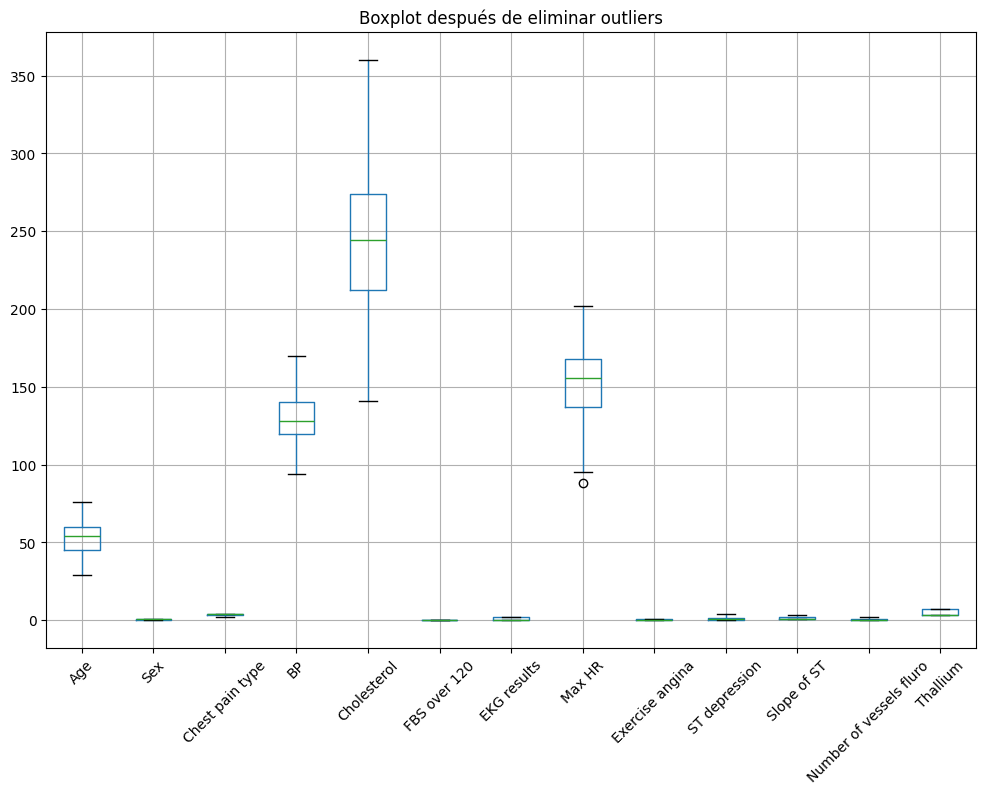

Estadísticas descriptivas de los datos normalizados:
               Age         Sex  Chest pain type          BP  Cholesterol  \
count  192.000000  192.000000       192.000000  192.000000   192.000000   
mean     0.514406    0.666667         0.669271    0.444490     0.480213   
std      0.194857    0.472637         0.384576    0.200254     0.200676   
min      0.000000    0.000000         0.000000    0.000000     0.000000   
25%      0.340426    0.000000         0.500000    0.335526     0.324201   
50%      0.531915    1.000000         1.000000    0.447368     0.472603   
75%      0.659574    1.000000         1.000000    0.605263     0.607306   
max      1.000000    1.000000         1.000000    1.000000     1.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count         192.0   192.000000  192.000000       192.000000     192.000000   
mean            0.0     0.476562    0.548702         0.317708       0.257668   
std             0.0     0.4994

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset
file_path = '/content/Heart_Disease_Prediction.csv'
heart_disease_data = pd.read_csv(file_path)

# Verificar valores nulos
missing_values = heart_disease_data.isnull().sum()
print("Valores nulos en el dataset:\n", missing_values)

# Eliminar outliers utilizando el método del rango intercuartil (IQR)
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Seleccionar columnas numéricas
numeric_cols = heart_disease_data.select_dtypes(include=['int64', 'float64']).columns

# Aplicar eliminación de outliers
heart_disease_data_cleaned = remove_outliers_iqr(heart_disease_data, numeric_cols)

# Graficar boxplots después de eliminar outliers
plt.figure(figsize=(12, 8))
heart_disease_data_cleaned[numeric_cols].boxplot(rot=45)
plt.title("Boxplot después de eliminar outliers")
plt.show()

# Normalización de variables numéricas
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(heart_disease_data_cleaned[numeric_cols])
normalized_df = pd.DataFrame(normalized_data, columns=numeric_cols)

# Mostrar estadísticas descriptivas después de la normalización
print("Estadísticas descriptivas de los datos normalizados:\n", normalized_df.describe())



# 2. Exploración y preprocesamiento de datos:

In [5]:
from sklearn.model_selection import train_test_split

# Verificar el balance de la variable objetivo antes de dividir
target_distribution = heart_disease_data_cleaned['Heart Disease'].value_counts(normalize=True)
print("Distribución de la variable objetivo (Heart Disease):\n", target_distribution)

# Dividir los datos en características (X) y objetivo (y)
X = heart_disease_data_cleaned.drop('Heart Disease', axis=1)
y = heart_disease_data_cleaned['Heart Disease']

# Dividir el dataset en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

# Verificar balance en los conjuntos de entrenamiento y prueba
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

print("\nDistribución de la variable objetivo en el conjunto de entrenamiento:\n", train_distribution)
print("\nDistribución de la variable objetivo en el conjunto de prueba:\n", test_distribution)

# Resultados finales
print("\nTamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Distribución de la variable objetivo (Heart Disease):
 Heart Disease
Absence     0.583333
Presence    0.416667
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto de entrenamiento:
 Heart Disease
Absence     0.581699
Presence    0.418301
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto de prueba:
 Heart Disease
Absence     0.589744
Presence    0.410256
Name: proportion, dtype: float64

Tamaño del conjunto de entrenamiento: (153, 13)
Tamaño del conjunto de prueba: (39, 13)


# 3. Implementación de la MLP con Dropout:

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Codificar la variable objetivo si es categórica
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Crear el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta 1
    Dropout(0.2),  # Dropout para prevenir sobreajuste
    Dense(32, activation='relu'),  # Capa oculta 2
    Dropout(0.3),  # Dropout adicional
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 4. Entrenamiento del modelo:

In [8]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Configurar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train_encoded,
    validation_split=0.2,  # Usar el 20% del conjunto de entrenamiento para validación
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
evaluation = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"\nPérdida en el conjunto de prueba: {evaluation[0]:.4f}")
print(f"Precisión en el conjunto de prueba: {evaluation[1]:.4f}")



Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5733 - loss: 5.9894 - val_accuracy: 0.6129 - val_loss: 0.8698
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5548 - loss: 6.6101 - val_accuracy: 0.7097 - val_loss: 0.8371
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5220 - loss: 4.7973 - val_accuracy: 0.6129 - val_loss: 1.0094
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5310 - loss: 5.7865 - val_accuracy: 0.6129 - val_loss: 1.4601
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5042 - loss: 3.6138 - val_accuracy: 0.6452 - val_loss: 1.0091
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5609 - loss: 4.5483 - val_accuracy: 0.5484 - val_loss: 0.8462
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6874 - loss: 2.6681 - val_accuracy: 0.4839 - val_loss: 0.8666

Pérdida en el conjunto de prueba: 0.8477
Precisión en el conjunto de prueba: 0.6923


# 5. Evaluación del modelo:

In [9]:
# Generar predicciones y un informe de clasificación
predictions = (model.predict(X_test) > 0.5).astype(int)
print("\nReporte de clasificación:\n", classification_report(y_test_encoded, predictions))
print("\nMatriz de confusión:\n", confusion_matrix(y_test_encoded, predictions))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.60      0.75      0.67        16

    accuracy                           0.69        39
   macro avg       0.69      0.70      0.69        39
weighted avg       0.71      0.69      0.69        39


Matriz de confusión:
 [[15  8]
 [ 4 12]]
